In [40]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
import finnhub
import time
import plotly.express as px
from random import sample

In [41]:
stocks2012 = pd.read_csv("stocks2012_inall.csv")

In [42]:
stocks2012.shape

(607, 12)

In [43]:
predictor_variables = stocks2012[['debtRatio','returnOnAssets','priceBookValueRatio','priceToFreeCashFlowsRatio','priceEarningsRatio','priceEarningsToGrowthRatio','debtEquityRatio']]
col_names = list(predictor_variables.columns)

In [44]:
s_scaler = preprocessing.StandardScaler()

In [45]:
df_s = s_scaler.fit_transform(predictor_variables)
df = pd.DataFrame(df_s, columns=col_names)
df.head()

,debtRatio,returnOnAssets,priceBookValueRatio,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,debtEquityRatio
0,-0.805626,0.348844,-0.028193,-10.303496,-0.047821,0.972588,-0.673220
1,-1.115769,0.514433,0.486834,0.114722,0.317130,0.026415,-0.721030
2,0.088437,0.076711,-0.122267,0.400067,0.937589,-0.007704,-0.410986
3,-0.030185,0.155502,-0.303209,-0.331926,-0.251406,0.037748,-0.464351
4,1.093875,0.025585,-0.254608,0.080372,0.394492,-0.141003,1.588692


In [46]:

# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [51]:
# inertia on the fitted data
kmeans.inertia_

1450.53289784123

Text(0, 0.5, 'Inertia')

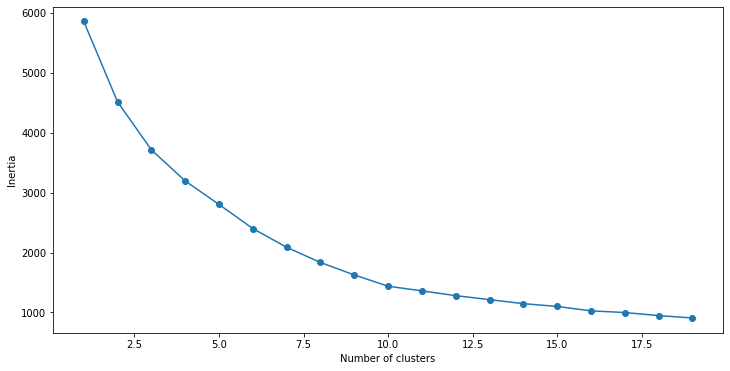

In [52]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [53]:
# k means using 8 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters =8, init='k-means++')
kmeans.fit(df)
pred = kmeans.predict(df)

In [54]:
frame = pd.DataFrame(df)
frame['cluster'] = pred

clustered_2012 = frame
frame['cluster'].value_counts()

0    199
2    179
1    148
3     51
7     17
5      9
4      3
6      1
Name: cluster, dtype: int64

In [55]:
# add the date and symbols back on
clustered_2012['Date'] = stocks2012['date'].values
clustered_2012['Symbol'] = stocks2012['symbol'].values

In [56]:
def callCounter():
    callCounter.counter += 1
    print(callCounter.counter)
callCounter.counter = 0

finnhub_client = finnhub.Client(api_key="c7rah32ad3icp4g2mrig")
def getPrice(stock):
    try:
        res = finnhub_client.stock_candles(stock, 'D', 1325376000, 1356998340)
        df = pd.DataFrame(res)
        df["Symbol"] = stock
    except:
        data = [[0,0,0,0,0,0,0,stock]]
        df = pd.DataFrame(data, columns = ['c', 'h', 'l', 'o', 's', 't', 'v', 'Symbol'])
    return df

In [57]:
symbols12 = clustered_2012['Symbol'].to_list()
df_list = []
annual_sharpe_ratio = {}
for ticker in symbols12:
    callCounter()
    if callCounter.counter %59 == 0:
        time.sleep(60)
    else:
        df1 = getPrice(ticker) 
        df_list.append(df1)

        
        

df_final_12 = pd.concat(df_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [79]:
df_final_12_symbols = df_final_12["Symbol"].unique()
annual_sharpe_ratio = {}
for stock in df_final_12_symbols:
    dataframe = df_final_12[df_final_12["Symbol"] == stock]
    data = dataframe[["c"]]
    log_return = np.sum(np.log(data/data.shift())*1, axis=1)
    sharpe_ratio = log_return.mean()/log_return.std()
    asr = sharpe_ratio*252**.5
    annual_sharpe_ratio[stock] = asr

sharpe_ratio2012 = pd.DataFrame(annual_sharpe_ratio.items(), columns = ["Symbol","Sharpe Ratio"])

In [80]:
df_all_2012 = clustered_2012.merge(df_final_12, on=['Symbol'], 
                   how='left', indicator=True)
mask_2012= df_all_2012["_merge"] == "left_only"
missedStocks_2012 = df_all_2012[mask_2012]
missedStocks_2012

,debtRatio,returnOnAssets,priceBookValueRatio,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,debtEquityRatio,cluster,Date,Symbol,c,h,l,o,s,t,v,_merge
13930,-1.459208,0.302705,-0.129503,2.763128,0.089805,0.167980,-0.761965,0,2012-04-30,AVAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
28171,-0.970671,0.668929,0.646293,0.044712,0.143272,0.106368,-0.700205,0,2012-06-30,CLCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
42525,-1.068338,0.495357,-0.115992,-0.035532,-0.288392,1.529317,-0.714490,0,2012-12-31,EBIX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
56324,0.691934,0.089393,-0.088152,-0.375436,0.101843,0.122296,0.128888,1,2012-12-31,GATX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
70261,-0.322941,0.925903,0.378628,0.099032,-0.375514,-0.007687,-0.565014,0,2012-12-31,IDCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
83841,0.950682,0.054824,-0.422389,-0.135332,-0.483094,-0.010115,0.783403,2,2012-12-31,MFNC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
97626,-0.336592,0.248075,-0.185757,0.116996,-0.201713,0.002760,-0.567907,1,2012-12-31,OLP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
111740,0.229098,-0.028828,0.032537,0.017935,-4.459407,0.023843,-0.333957,3,2012-12-31,RHP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
125407,1.109935,0.034494,-0.250495,-0.102264,-0.017939,1.136773,1.725035,2,2012-12-31,TCBK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
139161,-0.837842,0.245474,-0.189383,0.456260,-0.047663,0.080357,-0.678797,0,2012-12-31,WEYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [81]:
missedSymbols_2012 = missedStocks_2012["Symbol"].tolist()
df_missed_list_2012 = []

for ticker in missedSymbols_2012:
    callCounter()
    if callCounter.counter %59 == 0:
        time.sleep(60)
    else:
        df1 = getPrice(ticker) 
        df_missed_list_2012.append(df1)


df_final_missed_2012 = pd.concat(df_missed_list_2012)

618
619
620
621
622
623
624
625
626
627


In [82]:
df_final_12_missed_symbols = df_final_missed_2012["Symbol"].unique()
annual_sharpe_ratio_missed = {}
for stock in df_final_12_missed_symbols:
    dataframe = df_final_missed_2012[df_final_missed_2012["Symbol"] == stock]
    data = dataframe[["c"]]
    log_return = np.sum(np.log(data/data.shift())*1, axis=1)
    sharpe_ratio = log_return.mean()/log_return.std()
    asr = sharpe_ratio*252**.5
    annual_sharpe_ratio_missed[stock] = asr

sharpe_ratio_missed_2012 = pd.DataFrame(annual_sharpe_ratio_missed.items(), columns = ["Symbol","Sharpe Ratio"])

In [83]:
# concat with 1st dataframes 
sharpe_ratio_2012full = pd.concat([sharpe_ratio_missed_2012,sharpe_ratio2012], axis = 0)
df_final_2012full = pd.concat([df_final_missed_2012,df_final_12], axis = 0)

In [89]:
# calculate individual returns 
result_2012 = df_final_2012full.pivot_table(values='c',index=df_final_2012full.index,columns='Symbol')

In [90]:
# calculate annual returns
cum_return_2012 = (result_2012.iloc[-1] - result_2012.iloc[0]) / result_2012.iloc[0]
cum_returns_2012 = cum_return_2012.to_frame()
cum_returns_2012 = cum_returns_2012.rename(columns={0: "Annual_Return"})
cum_returns_2012 = cum_returns_2012.reset_index()

In [91]:
# compute daily returns using pandas pct_change()
df_daily_returns_2012 = result_2012.pct_change()



In [92]:
cum_returns_2012 = cum_returns_2012.rename(columns={"index":"Symbol"})

In [93]:
# order alphabetically
clustered_2012 = clustered_2012.sort_values(by=['Symbol'])

In [94]:
# add sharpe ratio 
sharpe_and_cumReturns= pd.merge(cum_returns_2012,sharpe_ratio_2012full)

In [95]:
# add annual returns 
clustered2012 =  pd.merge(clustered_2012,sharpe_and_cumReturns)
clustered2012= clustered2012[clustered2012['Sharpe Ratio'].notna()]
clustered2012= clustered2012[clustered2012['Annual_Return'].notna()]


In [96]:
# seperate clusters into seperate dataframes
mask0 = clustered2012["cluster"] == 0
group0 = clustered2012[mask0]
mask1 = clustered2012["cluster"] == 1
group1 = clustered2012[mask1]
mask2 = clustered2012["cluster"] == 2
group2 = clustered2012[mask2]
mask3 = clustered2012["cluster"] == 3
group3 = clustered2012[mask3]
mask4 = clustered2012["cluster"] == 4
group4 = clustered2012[mask4]
mask5 = clustered2012["cluster"] == 5
group5 = clustered2012[mask5]
mask6 = clustered2012["cluster"] == 6
group6 = clustered2012[mask6]
mask7 = clustered2012["cluster"] == 7
group7 = clustered2012[mask7]

In [97]:
# obtain 5 highest sharpe ratios of each cluster
group7Symbols = group7.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group6Symbols = group6.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group5Symbols = group5.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group4Symbols = group4.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group3Symbols = group3.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group2Symbols = group2.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group1Symbols = group1.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()
group0Symbols = group0.sort_values(by=["Sharpe Ratio"],ascending=False).head(1)['Symbol'].to_list()

In [98]:
portfolio2012_tickers =  group7Symbols+ group6Symbols + group5Symbols + group4Symbols + group3Symbols + group2Symbols + group1Symbols + group0Symbols

In [99]:
portfolio2012 = clustered2012[clustered2012["Symbol"].isin(portfolio2012_tickers)]
portfolio2012.to_csv("portfolio2012.top_stocks.csv")

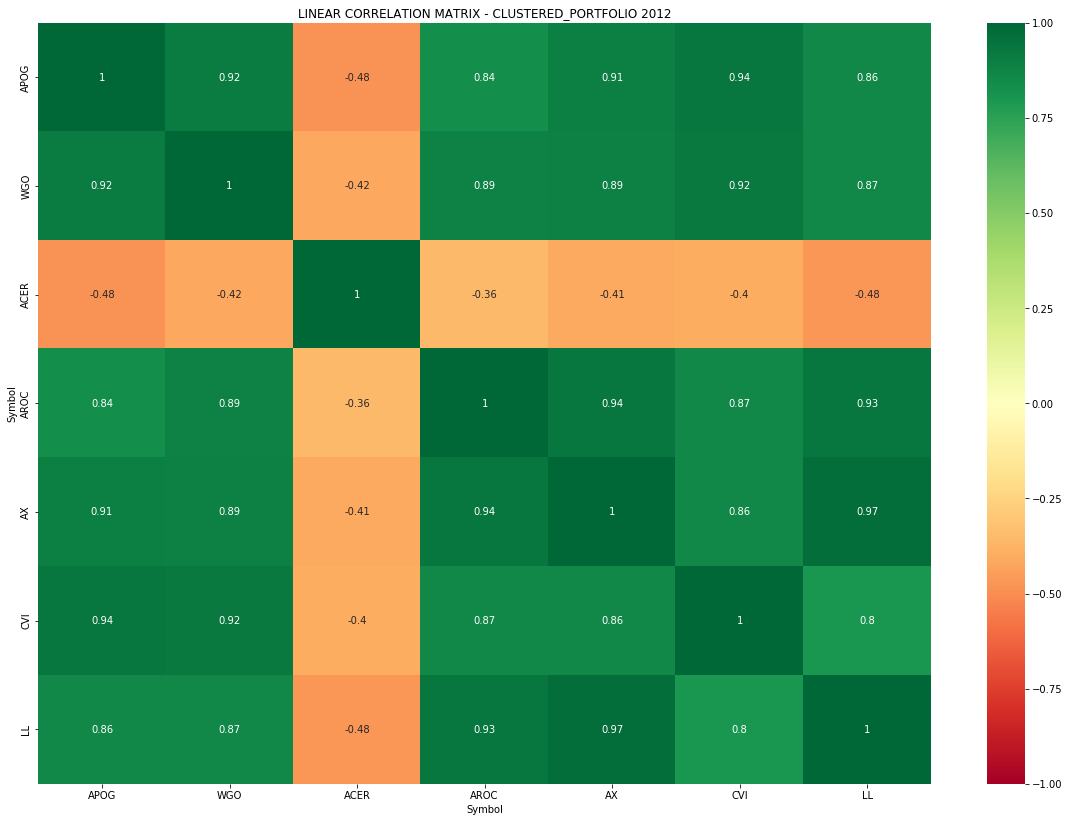

In [100]:
x = result_2012[portfolio2012_tickers]


fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(x.corr(), annot=True, cmap='RdYlGn', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('LINEAR CORRELATION MATRIX - CLUSTERED_PORTFOLIO 2012')
plt.show()

